In [39]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
with open('./mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

In [41]:
autos = datasets['autos']

In [42]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               193 non-null    object 
 1   fuel_type          193 non-null    object 
 2   aspiration         193 non-null    object 
 3   num_of_doors       193 non-null    int64  
 4   body_style         193 non-null    object 
 5   drive_wheels       193 non-null    object 
 6   engine_location    193 non-null    object 
 7   wheel_base         193 non-null    float64
 8   length             193 non-null    float64
 9   width              193 non-null    float64
 10  height             193 non-null    float64
 11  curb_weight        193 non-null    int64  
 12  engine_type        193 non-null    object 
 13  num_of_cylinders   193 non-null    int64  
 14  engine_size        193 non-null    int64  
 15  fuel_system        193 non-null    object 
 16  bore               193 non

In [43]:
autos.describe()

,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.160622,98.923834,174.326425,65.893782,53.869948,2561.507772,4.419689,128.124352,3.330622,3.248860,9.860104,103.481865,5099.740933,25.326425,30.787565,13285.025907
std,0.989583,6.152409,12.478593,2.137795,2.394770,526.700026,1.023182,41.590452,0.272385,0.315421,4.002098,37.960107,468.694369,6.387828,6.816910,8089.082886
min,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,3.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,98.000000,3.150000,3.110000,8.000000,70.000000,4800.000000,19.000000,25.000000,7738.000000
50%,4.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000,10245.000000
75%,4.000000,102.400000,184.600000,66.900000,55.700000,2952.000000,4.000000,146.000000,3.590000,3.410000,9.000000,116.000000,5500.000000,30.000000,34.000000,16515.000000
max,4.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


In [44]:
X = autos.copy()
y = X.pop('price')

cat_features = X.select_dtypes('object').columns

for colname in cat_features:
    X[colname], _ = X[colname].factorize()

discrete_features = cat_features.to_list() + ['num_of_doors','num_of_cylinders']

In [45]:
mi_scores = mutual_info_regression(
    X, y,
    discrete_features=X.columns.isin(discrete_features),
    random_state=42)

mi_scores = (pd.Series(
    mi_scores,
    name='MI Scores',
    index=X.columns))

In [46]:
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores}).set_index('Feature').sort_values(by='MI_Score', ascending=False)

In [47]:
encoder = TargetEncoder(cols=cat_features)
X_encoded = encoder.fit_transform(X, y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [50]:
feature_importances = model.feature_importances_
fi_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances}).set_index('Feature')

In [51]:
mi_df['Rank_MI'] = mi_df['MI_Score'].rank(pct=True)
fi_df['Rank_Importance'] = fi_df['Importance'].rank(pct=True)

In [52]:
combined_df = pd.merge(mi_df, fi_df, left_index=True, right_index=True, how='inner')
combined_df = combined_df.reset_index()
combined_df.sort_values(by="Rank_MI", ascending=False)
melted_df = combined_df.melt(id_vars='Feature', value_vars=['Rank_MI', 'Rank_Importance'], 
                             var_name='Metric', value_name='Rank')

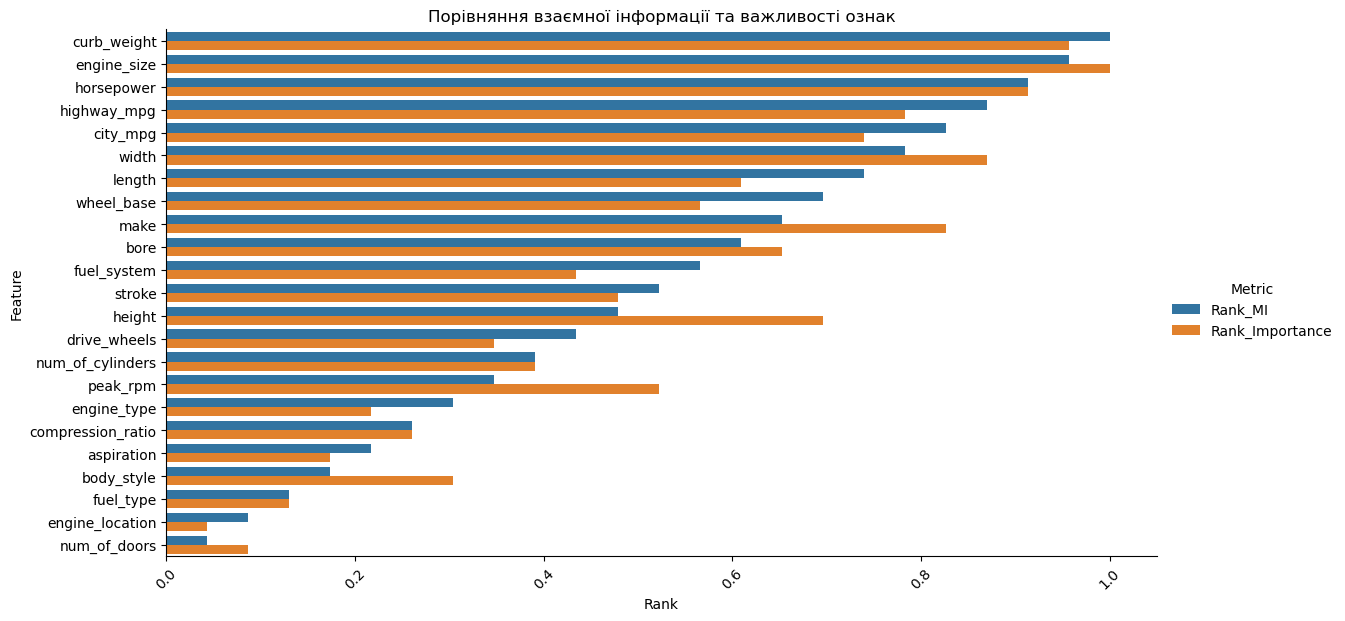

In [53]:
sns.catplot(data=melted_df, kind='bar', x='Rank', y='Feature', hue='Metric', height=6, aspect=2)
plt.title('Порівняння взаємної інформації та важливості ознак')
plt.xticks(rotation=45)
plt.show()

## Аналіз візуалізації:
1. Основні спостереження:

    - Взаємна інформація (Rank_MI): Найвищий рейтинг отримали такі ознаки: `curb_weight` (1.0), `engine_size` (0.9565), `horsepower` (0.9130). Ці змінні мають найбільшу взаємну інформацію із цільовою змінною price.
    - За важливістю ознак у моделі Random Forest: `engine_size` (1.0), `curb_weight` (0.9565), `horsepower` (0.9130). `engine_size` є найбільш вагомою характеристикою за обома метриками, що вказує на її критичний вплив.
2.Різниця між MI та Importance:
    - Сильний збіг:
        - Топ-3 ознаки (`engine_size`, `curb_weight`, `horsepower`) отримали високі рейтинги як за Rank_MI, так і за Rank_Importance.
        - Це підтверджує, що ознаки, які мають високу взаємну інформацію з цільовою змінною, також добре пояснюють модель Random Forest.
    - Різниця в ранжуванні:
        - Наприклад:
            - `highway_mpg`: Rank_MI = 0.8696, але Rank_Importance = 0.7826.
            - `make`: Rank_MI = 0.6522, але Rank_Importance = 0.8261.
    - Взаємна інформація краще враховує залежність ознаки від цільової змінної, тоді як Random Forest враховує також нелінійні взаємодії між ознаками.
3. Інтерпретація для моделювання:
    - Взаємна інформація та важливість ознак у Random Forest дають схожі результати для топових ознак (`engine_size`, `curb_weight`, `horsepower`).
    - Ознаки, які мають низький рейтинг за Rank_MI, загалом мають низький рейтинг і за Rank_Importance.
    - Random Forest враховує нелінійність, що може змінювати ранжування ознак середньої важливості.
### Висновки:
- Найважливішими ознаками для прогнозування ціни автомобіля є `engine_size`, `curb_weight` та `horsepower`.
- Rank_MI є корисним для оцінки прямої залежності ознаки від цільової змінної, тоді як Rank_Importance дає більше інформації про вплив у моделі. Їх комбінація дозволяє отримати більш глибоке розуміння значущості ознак.